In [1]:
from fastai.text import *
from sqlalchemy import create_engine

In [2]:
with open('psql_engine.txt') as f:
    psql = create_engine(f.read())
    
with open('lm_gpu/data_ru/tmp/itos.pkl', 'rb') as fru, open('lm_gpu/data_uk/tmp/itos.pkl', 'rb') as fuk:
    itos_ru = pickle.load(fru)
    itos_uk = pickle.load(fuk)

In [3]:
%%capture
bptt,em_sz,nh,nl,c = 70,400,1150,3,2
vs = len(itos_ru)
bs = 2

sigm = lambda x: 1 / (1 + np.exp(-x))
sigmv = np.vectorize(sigm)

m_pred = get_rnn_classifer(bptt, 25*70, 2, vs,
                           emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
                           drops=[0,0],
                           layers=[em_sz*3, 50, c])

load_model(m_pred, 'classifiers/arg_2_mult_best54.h5')

m_pred.cuda()
m_pred.eval()

## each activation on small sample

In [4]:
# html_ids

to_check = '688276, 1731042, 2463925, 2493020, 938827, 1809868, 2889683, 290087, 1598581, 2495822, 2058441, 3019198'

In [20]:
check_ids = pd.read_sql(f'''
    select html_id, tokenized, ra_title, word_ids, lang
    from htmls
    where html_id in ({to_check});
    ''', psql)

In [7]:
ds_ru = TextDataset(check_ids.loc[check_ids.lang == 'ru'].word_ids.values, check_ids.loc[check_ids.lang == 'ru'].html_id.values)
dl_ru = DataLoader(ds_ru, 24, transpose=True, num_workers=3, pad_idx=1)

In [8]:
result = m_pred(V(next(iter(dl_ru))[0]))

preds_ru = sigmv(result[0].data.cpu().numpy())
ru_states = []
for i in range(len(ds_ru)):
    ru_states.append(result[-1][-1][:, i, :].data.cpu().numpy())
    
del result

In [9]:
BOS = 'xbos'
FLD = 'xbod'

def split_tok(text):
    return' \n '.join([p.replace('\n', f' {BOS} ')
                       for p in text.strip().split('\n\n')]
                     ).split(' ')

In [10]:
splitted_ru = (f'\n{BOS} {FLD} 1 ' + check_ids.loc[check_ids.lang == 'ru'].tokenized
              ).apply(split_tok).values.tolist()

In [11]:
states_of_news = {}
for splited, states, preds, html_id in zip(splitted_ru, ru_states, preds_ru, ds_ru.y):
    states_per_word = np.hstack([np.array(splited)[:, None], states[-len(splited):]]).tolist()
    states_of_news[str(html_id)] = {
        'states_per_word': states_per_word,
        'pred_emo': preds[0],
        'pred_arg': preds[1],
    }
    

In [19]:
for k, v in states_of_news.items():
    with open(f'states_data/{k}.json', 'w') as f:
        json.dump(v, f, ensure_ascii=False, allow_nan=False)

In [28]:
check_ids.loc[check_ids.lang == 'ru', ['html_id', 'ra_title']
             ].to_json('states_data/file_index.json', orient='records', force_ascii=False)

## Regression to find LM vector weights

In [11]:
ru_ann = pd.read_csv('ru_annotation.csv')
ru_ann = ru_ann.loc[ru_ann.is_other == 0].copy().drop(['is_other'], axis=1)
ru_ids = ', '.join(ru_ann.html_id.astype(str).values)

ru_ann = ru_ann.merge(pd.read_sql(f'''
    select html_id, word_ids
    from htmls
    where html_id in ({ru_ids})
      and word_ids notnull
    ''', psql), on='html_id', how='inner')

ru_ann = ru_ann.loc[ru_ann.word_ids.apply(lambda l: len(l) < 1200)].copy()
del ru_ids

In [5]:
ds_ru = TextDataset(ru_ann.word_ids.values, ru_ann.html_id.values)
dl_ru = DataLoader(ds_ru, bs, transpose=True, num_workers=3, pad_idx=1)

In [6]:
def pool(x, bs, is_max):
    f = F.adaptive_max_pool1d if is_max else F.adaptive_avg_pool1d
    return f(x.permute(1,2,0), (1,)).view(bs,-1)

final_outputs = {}
for x, y in tqdm(dl_ru):
    m_pred.eval()
    m_pred.reset()
    output = m_pred[0](V(x))[-1][-1]
    avgpool = pool(output, bs, False)
    mxpool = pool(output, bs, True)
    x = torch.cat([output[-1], mxpool, avgpool], 1).data.cpu().numpy()
    y = y.cpu().numpy()
    final_outputs = {**final_outputs, **dict(zip(y, x))}

100%|██████████| 2977/2977 [15:32<00:00,  3.99it/s]


In [12]:
ru_ann['pred_vec'] = ru_ann.html_id.apply(lambda i: final_outputs[i])

In [15]:
ru_ann_trn = ru_ann.loc[ru_ann.trn_val == 'trn'].copy().drop('trn_val', axis=1)
ru_ann_val = ru_ann.loc[ru_ann.trn_val == 'val'].copy().drop('trn_val', axis=1)

### lr

In [28]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import *

In [29]:
lr_emo = SGDClassifier(loss='log', penalty='l1', alpha=0.001, verbose=True)
lr_arg = SGDClassifier(loss='log', penalty='l1', alpha=0.001, verbose=True)

In [30]:
lr_emo.fit(np.vstack(ru_ann_trn.pred_vec.values), ru_ann_trn.is_emo)
lr_arg.fit(np.vstack(ru_ann_trn.pred_vec.values), ru_ann_trn.is_arg)

/home/nadiiaromanenko/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


-- Epoch 1
Norm: 155.83, NNZs: 237, Bias: -1.752521, T: 4742, Avg. loss: 4.736963
Total training time: 0.08 seconds.
-- Epoch 2
Norm: 155.51, NNZs: 175, Bias: -1.000431, T: 9484, Avg. loss: 0.916834
Total training time: 0.16 seconds.
-- Epoch 3
Norm: 155.50, NNZs: 145, Bias: -0.754904, T: 14226, Avg. loss: 0.605530
Total training time: 0.23 seconds.
-- Epoch 4
Norm: 155.56, NNZs: 129, Bias: -1.006772, T: 18968, Avg. loss: 0.499151
Total training time: 0.31 seconds.
-- Epoch 5
Norm: 155.63, NNZs: 118, Bias: -0.884166, T: 23710, Avg. loss: 0.455274
Total training time: 0.38 seconds.


/home/nadiiaromanenko/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


-- Epoch 1
Norm: 100.28, NNZs: 70, Bias: -2.087879, T: 4742, Avg. loss: 0.924333
Total training time: 0.07 seconds.
-- Epoch 2
Norm: 101.42, NNZs: 46, Bias: -2.188433, T: 9484, Avg. loss: 0.180435
Total training time: 0.15 seconds.
-- Epoch 3
Norm: 101.85, NNZs: 38, Bias: -2.517374, T: 14226, Avg. loss: 0.174461
Total training time: 0.22 seconds.
-- Epoch 4
Norm: 102.09, NNZs: 39, Bias: -2.598665, T: 18968, Avg. loss: 0.169521
Total training time: 0.29 seconds.
-- Epoch 5
Norm: 102.24, NNZs: 39, Bias: -2.818299, T: 23710, Avg. loss: 0.169908
Total training time: 0.37 seconds.


SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [53]:
emo_params = dict(
    y_pred=lr_emo.predict(np.vstack(ru_ann_val.pred_vec.values)),
    y_true=ru_ann_val.is_emo,
    labels=[1,0]
)

arg_params = dict(
    y_pred=lr_arg.predict_proba(np.vstack(ru_ann_val.pred_vec.values))[:, 1] > 0.05,
    y_true=ru_ann_val.is_arg,
    labels=[1,0]
)

def print_metrics(params, s):
    print(s)
    print(classification_report(**params))
    cm = confusion_matrix(**params)
    print(cm / cm.sum(1)[:, None])
    print(cm)
    
print_metrics(emo_params, 'EMO')
print_metrics(arg_params, 'ARG')

EMO
              precision    recall  f1-score   support

           1       0.37      0.53      0.43       164
           0       0.92      0.86      0.89      1048

   micro avg       0.81      0.81      0.81      1212
   macro avg       0.64      0.69      0.66      1212
weighted avg       0.85      0.81      0.83      1212

[[0.53049 0.46951]
 [0.14313 0.85687]]
[[ 87  77]
 [150 898]]
ARG
              precision    recall  f1-score   support

           1       0.41      0.19      0.26       203
           0       0.85      0.95      0.90      1009

   micro avg       0.82      0.82      0.82      1212
   macro avg       0.63      0.57      0.58      1212
weighted avg       0.78      0.82      0.79      1212

[[0.19212 0.80788]
 [0.05451 0.94549]]
[[ 39 164]
 [ 55 954]]


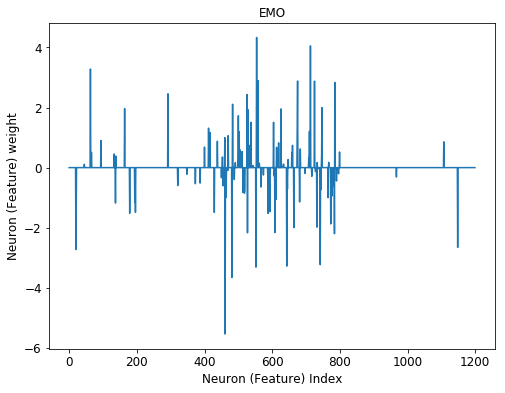

In [50]:
plt.figure(figsize=(8,6))
plt.tick_params(axis='both', which='major', labelsize=12)
plt.plot(range(len(lr_emo.coef_[0])), lr_emo.coef_.T)
plt.xlabel('Neuron (Feature) Index', size=12)
plt.ylabel('Neuron (Feature) weight', size=12)
plt.title('EMO')
plt.show()

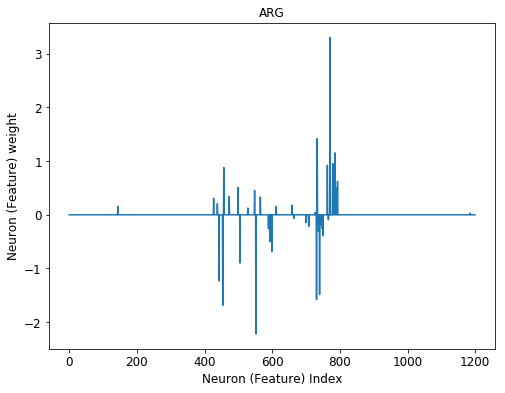

In [49]:
plt.figure(figsize=(8,6))
plt.tick_params(axis='both', which='major', labelsize=12)
plt.plot(range(len(lr_arg.coef_[0])), lr_arg.coef_.T)
plt.xlabel('Neuron (Feature) Index', size=12)
plt.ylabel('Neuron (Feature) weight', size=12)
plt.title('ARG')
plt.show()